# 3. AE for reconstruction

In [2]:
import importlib
import argparse
import os, sys
import argparse
import pandas as pd
import numpy as np
import pickle
import time

In [3]:
import torch
import torch.utils.data
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler
from torch.autograd import Variable
from torchvision import transforms

In [4]:
sys.path.insert(0, './../utils/')
from utils import *
from models import *

In [5]:
#Define parser
name = 'small_log'


parser = {
    'train': True,
    'test': True,
    'model_class': 'AE',
    'model_name': '',
    'data_dir': '../data/',
    'data_file': name + '.csv',
    'nan_pct': 0.3,
    'input_dir': '../input/{}/'.format(name),
    'batch_size' : 16,
    'epochs' : 200,
    'no_cuda' : False,
    'seed' : 7,
    'layer1': 300,
    'layer2': 100,
    'lr': 0.0005,
    'betas': (0.9, 0.999),   
    'lr_decay': 0.90,
}

args = argparse.Namespace(**parser)
args.output_dir = './output/{0}_{1}_{2}/'.format(name, args.nan_pct, args.model_class)

In [6]:
if not os.path.isdir(args.output_dir):
    os.makedirs(args.output_dir)

In [7]:
args.cuda = not args.no_cuda and torch.cuda.is_available()

In [8]:
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

In [9]:
kwargs = {'num_workers': 2, 'pin_memory': True} if args.cuda else {}

In [10]:
preprocessed_data_name = os.path.join(args.input_dir, 'preprocessed_data_full_{}.pkl'.format(args.nan_pct))

with open(preprocessed_data_name, 'rb') as f:
    min_max_storage = pickle.load(f)
    complete_matrix_w_normalized_time = pickle.load(f)
    missing_matrix_w_normalized_time = pickle.load(f)
    avai_matrix = pickle.load(f)
    nan_matrix = pickle.load(f)
    pad_matrix = pickle.load(f)
    cols_w_time = pickle.load(f)
    cols_w_normalized_time = pickle.load(f)

In [11]:
file_name = os.path.join(args.input_dir, 'parameters_{}.pkl'.format(args.nan_pct))

with open(file_name, 'rb') as f:
    most_frequent_activity = pickle.load(f)
    first_timestamp = pickle.load(f)
    
    avai_instance = pickle.load(f)
    nan_instance = pickle.load(f)
    
    train_size = pickle.load(f)
    val_size = pickle.load(f)
    test_size = pickle.load(f)
    
    train_row_num = pickle.load(f)
    val_row_num = pickle.load(f)
    test_row_num = pickle.load(f)

## Loading data

In [12]:
complete_matrix_w_normalized_time_trainLoader = torch.utils.data.DataLoader(complete_matrix_w_normalized_time, 
                                                                            batch_size=args.batch_size, shuffle=False, 
                                                                            num_workers=0)
missing_matrix_w_normalized_time_trainLoader = torch.utils.data.DataLoader(missing_matrix_w_normalized_time, 
                                                                           batch_size=args.batch_size, shuffle=False, 
                                                                           num_workers=0)
avai_matrix_trainLoader = torch.utils.data.DataLoader(avai_matrix, 
                                                      batch_size=args.batch_size, shuffle=False, 
                                                      num_workers=0)

In [13]:
normalized_complete_df_name = os.path.join(args.input_dir, 'normalized_complete_df_{}.csv'.format(args.nan_pct))
normalized_complete_df = pd.read_csv(normalized_complete_df_name)

normalized_missing_df_name = os.path.join(args.input_dir, 'normalized_missing_df_{}.csv'.format(args.nan_pct))
normalized_missing_df = pd.read_csv(normalized_missing_df_name)

In [14]:
missing_true_test = normalized_missing_df
complete_true_test = normalized_complete_df

In [15]:
nan_time_index, nan_activity_index = getnanindex(missing_true_test)

In [16]:
row_num = missing_true_test.shape[0]
row_num

28000

In [17]:
complete_matrix_w_normalized_time.shape

(2000, 14, 15)

## Building the model

### Define model

In [ ]:
if args.model_class == 'AE':
    model = AE(complete_matrix_w_normalized_time.shape, args.layer1, args.layer2)

if args.cuda:
    model.cuda()

/content/./utils/models.py:28: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.fc1.weight, gain=np.sqrt(2))
/content/./utils/models.py:29: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.fc2.weight, gain=np.sqrt(2))


### Define loss

In [ ]:
# Define loss

def loss_function(recon_x, x, avai_mask):
    #MSE = F.mse_loss(recon_x*avai_mask, x*avai_mask, size_average=False)
    BCE = F.binary_cross_entropy(recon_x, x, weight=avai_mask, size_average=False) 
    return BCE

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=args.lr, betas=args.betas)

In [ ]:
#Adjust learning rate per epoch: 

lambda1 = lambda epoch: args.lr_decay ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])


## Utility fucntions

In [38]:
def save_model(model, epoch, score):
    model_file = os.path.join(args.output_dir, 'model_{}_epoch{}_score{:.4f}.pth'.format(args.model_class, epoch, score))
    torch.save(model.state_dict(), model_file)

In [39]:
def load_model(model, model_name):
    model_file = os.path.join(args.output_dir, model_name)
    assert os.path.isfile(model_file), 'Error: no model found!'
    model_state = torch.load(model_file)
    model.load_state_dict(model_state)

## Training the model

In [40]:
def train(epoch, model, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (m_data, c_data, avai_mask) in enumerate(zip(missing_matrix_w_normalized_time_trainLoader, 
                                                                complete_matrix_w_normalized_time_trainLoader,
                                                                avai_matrix_trainLoader)):
        c_data = Variable(c_data.float())
        m_data = Variable(m_data.float())
        avai_mask = Variable(avai_mask.float())

        if args.cuda:
            c_data = c_data.cuda()
            m_data = m_data.cuda()
            avai_mask = avai_mask.cuda()

            
        optimizer.zero_grad()
        
        recon_data = model(m_data)
        
        loss = loss_function(recon_data, c_data, avai_mask)
        
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        
    return train_loss / len(complete_matrix_w_normalized_time_trainLoader.dataset)

In [ ]:
if args.train:
    for epoch in range(1, args.epochs + 1):
        init = time.time()

        #method 1 scheduler
        scheduler.step()
        train_loss = train(epoch, model, optimizer)

        end = time.time()
        print('====> Epoch {} | End time: {:.4f} ms | Train loss: {:.4f}'.
              format(epoch, (end-init)*1000, train_loss))
else:
    load_model(model, args.model_name)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


====> Epoch 1 | End time: 22882.1537 ms | Train loss: 11.7908
====> Epoch 2 | End time: 28679.6563 ms | Train loss: 5.1268
====> Epoch 3 | End time: 12365.7978 ms | Train loss: 4.8785
====> Epoch 4 | End time: 9766.6259 ms | Train loss: 4.8436
====> Epoch 5 | End time: 10416.3802 ms | Train loss: 4.8323
====> Epoch 6 | End time: 11456.2271 ms | Train loss: 4.8274
====> Epoch 7 | End time: 10156.9495 ms | Train loss: 4.8247
====> Epoch 8 | End time: 11785.6154 ms | Train loss: 4.8231
====> Epoch 9 | End time: 11204.1972 ms | Train loss: 4.8221
====> Epoch 10 | End time: 10053.0684 ms | Train loss: 4.8214
====> Epoch 11 | End time: 13285.7554 ms | Train loss: 4.8209
====> Epoch 12 | End time: 11628.0992 ms | Train loss: 4.8205
====> Epoch 13 | End time: 10962.0583 ms | Train loss: 4.8203
====> Epoch 14 | End time: 9971.1719 ms | Train loss: 4.8201
====> Epoch 15 | End time: 11163.6596 ms | Train loss: 4.8199
====> Epoch 16 | End time: 12155.6759 ms | Train loss: 4.8198
====> Epoch 17 | E

## Predict and evaluate

In [25]:
pad_matrix.shape

(2000, 14, 15)

In [26]:
missing_matrix_w_normalized_time.shape

(2000, 14, 15)

In [27]:
if args.test:
    m_test = missing_matrix_w_normalized_time
    m_test = Variable(torch.Tensor(m_test).float())
    
    if args.cuda:
        m_test = m_test.cuda()
    
    print('Predicting...')
    recon_test = model(m_test)
    
    print('recon_test shape: ', recon_test.shape)
    
    print('\n')
    print('Converting to dataframe...')
    recon_df_w_normalized_time = convert2df(recon_test, pad_matrix, cols_w_normalized_time, row_num)
    
    print('Transforming Normalized Time to Time...')
    recon_df_w_time = getDfWithTime(recon_df_w_normalized_time, missing_true_test, min_max_storage)
    
    print('Getting submission...')
    submission_df = getSubmission(recon_df_w_time, missing_true_test, complete_true_test, first_timestamp)
    submission = fixTime(submission_df)
    
    print('Testing...')
    mae_time, rmse_time, acc = evaluation(submission, nan_time_index, nan_activity_index, show=True)
    print('\n')
    
    print('Saving submission...')
    submission_df.to_csv(args.output_dir+'submission.csv', index=False)
    print('Done!')

Predicting...
recon_test shape:  torch.Size([2000, 14, 15])


Converting to dataframe...


./../utils\utils.py:129: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_values = softmax(recon_test[i, :, 1:])


Transforming Normalized Time to Time...
Getting submission...
Testing...
Number of missing Time: 8498
Mean Absolute Error: 0.0189 day(s)
Root Mean Squared Error: 0.0329 day(s)
Number of missing Activity: 8302
Accuracy: 97.05%


Saving submission...
Done!


### Accuracy = 97.05%

In [28]:
submission_df.shape

(28000, 7)

In [78]:
submission.head(30)

,CaseID,TrueActivity,PredictedActivity,TrueTime,PredictedTime,TrueCompleteTimestamp,PredictedCompleteTimestamp
0,1,Activity A,Activity A,0.0,0.000000,1970-01-01 09:00:00,1970-01-01 09:00:00
1,1,Activity B,Activity B,3600.0,3600.000000,1970-01-01 10:00:00,1970-01-01 10:00:00
2,1,Activity C,Activity C,7200.0,7200.000000,1970-01-01 11:00:00,1970-01-01 11:00:00
3,1,Activity D,Activity D,10800.0,9395.238465,1970-01-01 12:00:00,1970-01-01 11:36:35.238465
4,1,Activity E,Activity E,14400.0,14400.000000,1970-01-01 13:00:00,1970-01-01 13:00:00
5,1,Activity K,Activity K,18000.0,15623.838316,1970-01-01 14:00:00,1970-01-01 13:20:23.838316
6,1,Activity G,Activity G,18000.0,18000.000000,1970-01-01 14:00:00,1970-01-01 14:00:00
7,1,Activity M,Activity M,18000.0,18000.000000,1970-01-01 14:00:00,1970-01-01 14:00:00
8,1,Activity L,Activity L,21600.0,21600.000000,1970-01-01 15:00:00,1970-01-01 15:00:00
9,1,Activity I,Activity I,21600.0,21600.000000,1970-01-01 15:00:00,1970-01-01 15:00:00


In [30]:
missing_true_test.head(10)

,CaseID,Activity,CompleteTimestamp,CumTimeInterval,NormalizedTime
0,1,Activity A,1970-01-01 09:00:00,0.0,0.000000
1,1,NaN,1970-01-01 10:00:00,3600.0,0.142857
2,1,Activity C,1970-01-01 11:00:00,7200.0,0.285713
3,1,NaN,NaN,NaN,NaN
4,1,NaN,1970-01-01 13:00:00,14400.0,0.571426
5,1,Activity K,NaN,NaN,NaN
6,1,Activity G,1970-01-01 14:00:00,18000.0,0.714283
7,1,Activity M,1970-01-01 14:00:00,18000.0,0.714283
8,1,Activity L,1970-01-01 15:00:00,21600.0,0.857139
9,1,Activity I,NaN,NaN,NaN


# Using PM4Py on reconstructed data

## Import PM4Py

In [31]:
!pip install pm4py

Note: you may need to restart the kernel to use updated packages.


In [32]:
import pm4py

## Load Reconstructed Dataframe

In [33]:
recons_dataframe = submission[['CaseID', 'PredictedActivity', 'PredictedCompleteTimestamp']]
recons_dataframe.head()

,CaseID,PredictedActivity,PredictedCompleteTimestamp
0,1,Activity A,1970-01-01 09:00:00
1,1,Activity B,1970-01-01 10:00:00
2,1,Activity C,1970-01-01 11:00:00
3,1,Activity D,1970-01-01 11:36:35.238465
4,1,Activity E,1970-01-01 13:00:00


In [34]:
recons_dataframe.rename(columns={'CaseID':'case:concept:name','PredictedActivity':'concept:name', 'PredictedCompleteTimestamp': 'time:timestamp'}, inplace=True)

C:\Users\AREFA\miniconda3\envs\papercodeenv\lib\site-packages\pandas\core\frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [35]:
recons_dataframe.head()

,case:concept:name,concept:name,time:timestamp
0,1,Activity A,1970-01-01 09:00:00
1,1,Activity B,1970-01-01 10:00:00
2,1,Activity C,1970-01-01 11:00:00
3,1,Activity D,1970-01-01 11:36:35.238465
4,1,Activity E,1970-01-01 13:00:00


## Convert Reconstructed Dataframe to Event log

In [36]:
recons_dataframe = pm4py.format_dataframe(recons_dataframe, case_id='case:concept:name', activity_key='concept:name', timestamp_key='time:timestamp')
event_log = pm4py.convert_to_event_log(recons_dataframe)

C:\Users\AREFA\miniconda3\envs\papercodeenv\lib\site-packages\pm4py\objects\log\util\dataframe_utils.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_datetime(df[col], utc=True, infer_datetime_format=True)


## Process Discovery from reconstructed Event log

### 1. Inductive Miner

In [37]:
#using inductive miner to discover petri net model
petri_net_im, initial_marking, final_marking = pm4py.discover_petri_net_inductive(event_log)

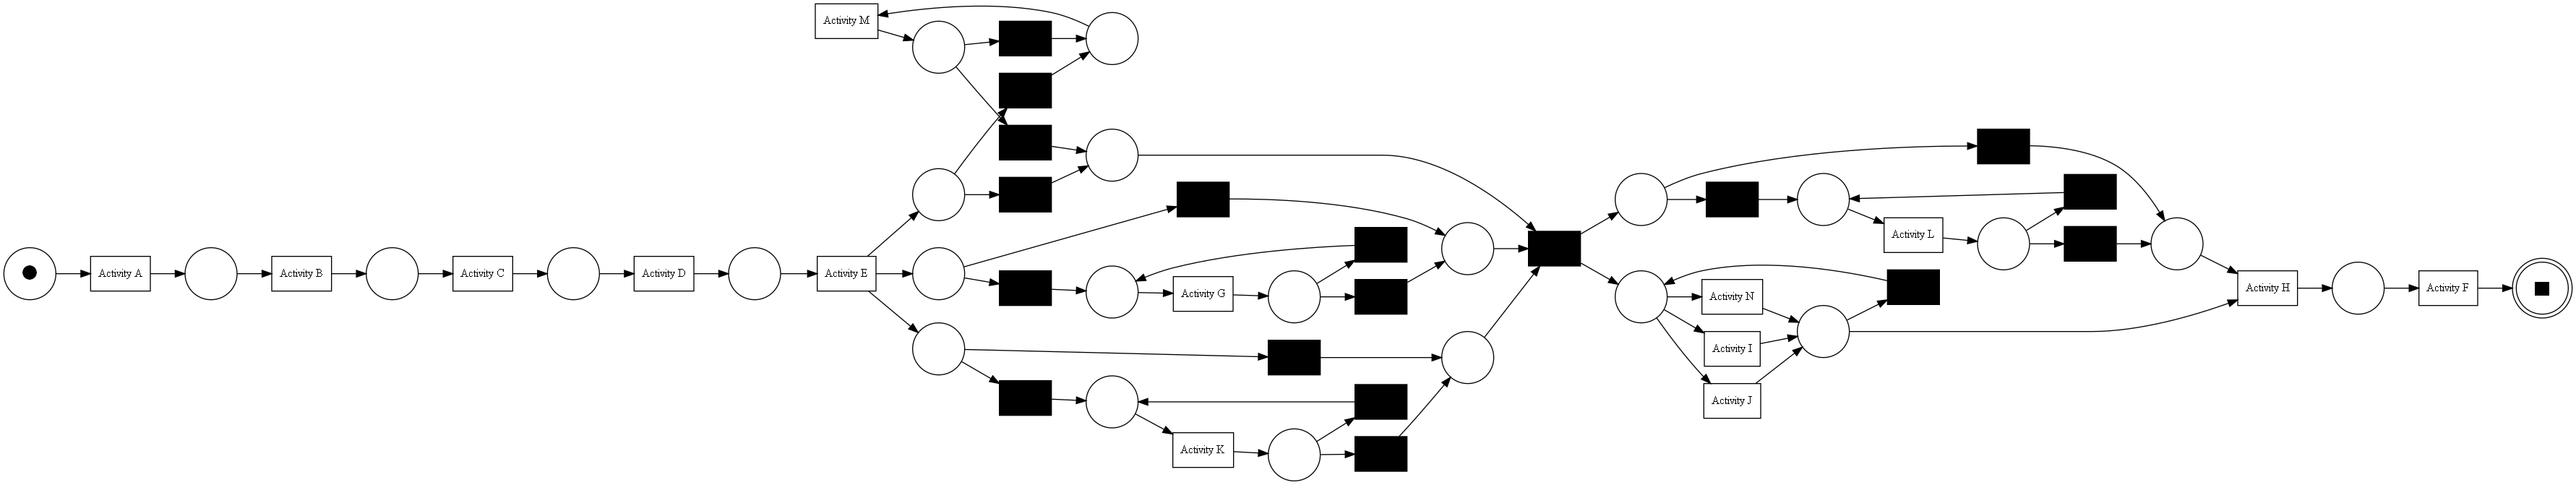

In [38]:
#visualizing the petri net
from pm4py.visualization.petri_net import visualizer as pn_visualizer
gviz1 = pn_visualizer.apply(petri_net_im, initial_marking, final_marking)
pn_visualizer.view(gviz1)

### 2. Heuristics Miner

In [39]:
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
heu_net = heuristics_miner.apply_heu(event_log, 
                                     parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.6})

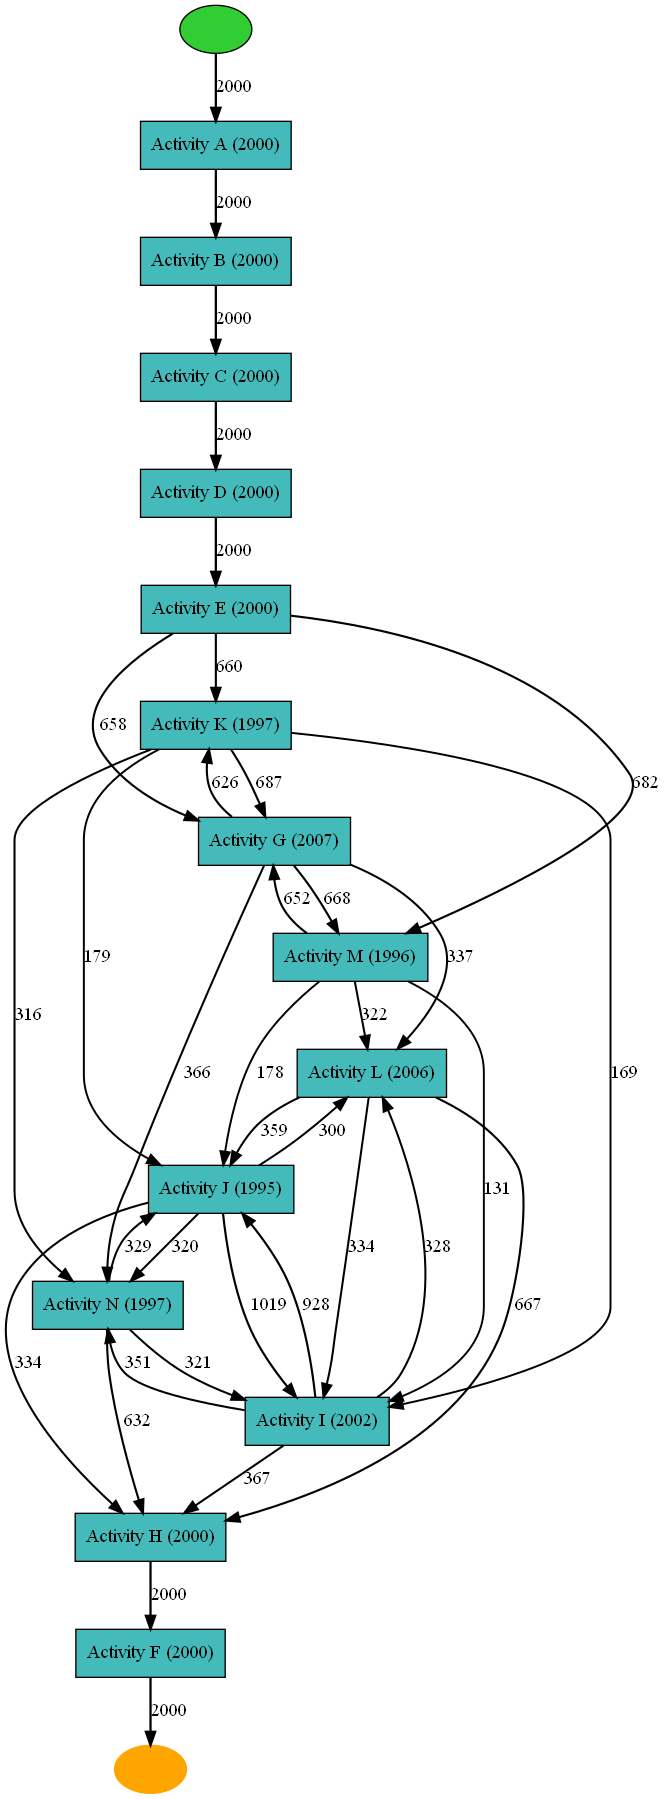

In [40]:
#visualizing the heuristics net
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
gviz_h = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz_h)

### 3. Alpha Miner

In [41]:
#applying the alpha miner
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
petri_net_am, initial_markingg, final_markingg = alpha_miner.apply(event_log)

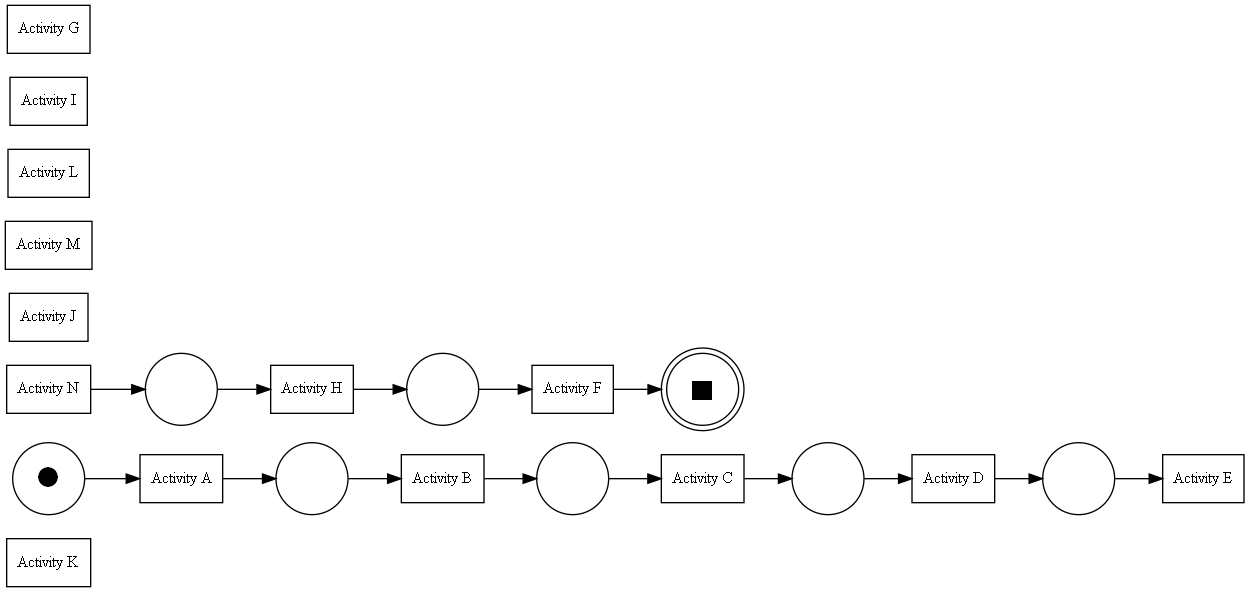

In [42]:
#visualizing the petri net
gviz2 = pn_visualizer.apply(petri_net_am, initial_markingg, final_markingg)
pn_visualizer.view(gviz2)

## Analyzing original event log on discovered petri net model

In [43]:
file_name_2 = os.path.join(args.input_dir, 'preprocessed_data_{}.pkl'.format(args.nan_pct))

with open(preprocessed_data_name, 'rb') as f:
    input_train = pickle.load( f)
    input_val = pickle.load(f)
    input_test = pickle.load(f)


In [44]:
data = pd.read_csv(args.data_dir + args.data_file, usecols=['Case ID', 'Activity', 'Complete Timestamp'])
data.head()

,Case ID,Activity,Complete Timestamp
0,Case 1,Activity A,1970/01/01 09:00:00.000
1,Case 1,Activity B,1970/01/01 10:00:00.000
2,Case 1,Activity C,1970/01/01 11:00:00.000
3,Case 1,Activity D,1970/01/01 12:00:00.000
4,Case 1,Activity E,1970/01/01 13:00:00.000


In [45]:
cols = ['case:concept:name', 'concept:name', 'time:timestamp']
data.columns = cols
data.head()

,case:concept:name,concept:name,time:timestamp
0,Case 1,Activity A,1970/01/01 09:00:00.000
1,Case 1,Activity B,1970/01/01 10:00:00.000
2,Case 1,Activity C,1970/01/01 11:00:00.000
3,Case 1,Activity D,1970/01/01 12:00:00.000
4,Case 1,Activity E,1970/01/01 13:00:00.000


In [46]:
# Convert Timestamp to time
data['time:timestamp'] = pd.to_datetime(data['time:timestamp'], errors='coerce')
# Format Case column
data['case:concept:name'] = data['case:concept:name'].apply(lambda x: x.split(' ')[1])
data['case:concept:name'] = data['case:concept:name'].apply(pd.to_numeric)

In [47]:
event_log_orig = pm4py.convert_to_event_log(data)

### Token Based Replay of original event log on petri net of reconstructed log

In [48]:
replayed_traces_im_orig = pm4py.conformance_diagnostics_token_based_replay(event_log_orig, petri_net_im, initial_marking, final_marking)

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

In [49]:
replayed_traces_im_orig[100]

{'trace_is_fit': True,
 'trace_fitness': 1.0,
 'activated_transitions': [(7211c563-00dd-4621-aea5-2bc61bd78fd4, 'Activity A'),
  (63d16318-d31a-4fc1-8a05-94a6bead2d2d, 'Activity B'),
  (53666492-d539-439e-a44b-f3e6542589f0, 'Activity C'),
  (7eb5c9b2-0029-41c2-812c-59099e679ad8, 'Activity D'),
  (40aeac1f-671c-4df5-8dee-500406c8dfef, 'Activity E'),
  (init_loop_4, None),
  (eebd0548-2cb5-4b41-a5d1-5c8dddf2e3c8, 'Activity K'),
  (init_loop_9, None),
  (a5f52a86-25ec-4da8-b2ff-312a3bd9152c, 'Activity M'),
  (init_loop_14, None),
  (cabd8ba8-77d0-4805-9faa-a30490c10ffe, 'Activity G'),
  (skip_7, None),
  (skip_12, None),
  (skip_17, None),
  (tauJoin_2, None),
  (init_loop_21, None),
  (3c15908e-bee2-458e-86b2-5238810b4e85, 'Activity L'),
  (71086467-dfdf-4a96-86cd-57e6376eda3b, 'Activity N'),
  (skip_27, None),
  (9ecdb12d-546c-4108-94c7-a9ee3c0ea66d, 'Activity I'),
  (skip_27, None),
  (8145b108-4b8f-48cd-abbb-70d60087fd98, 'Activity J'),
  (skip_24, None),
  (40c7d8ce-8ef4-434e-8a68-57

### Obtaining Petri Net from original log

In [50]:
#using inductive miner to discover petri net model
petri_net_im_orig, initial_marking_orig, final_marking_orig = pm4py.discover_petri_net_inductive(event_log_orig)

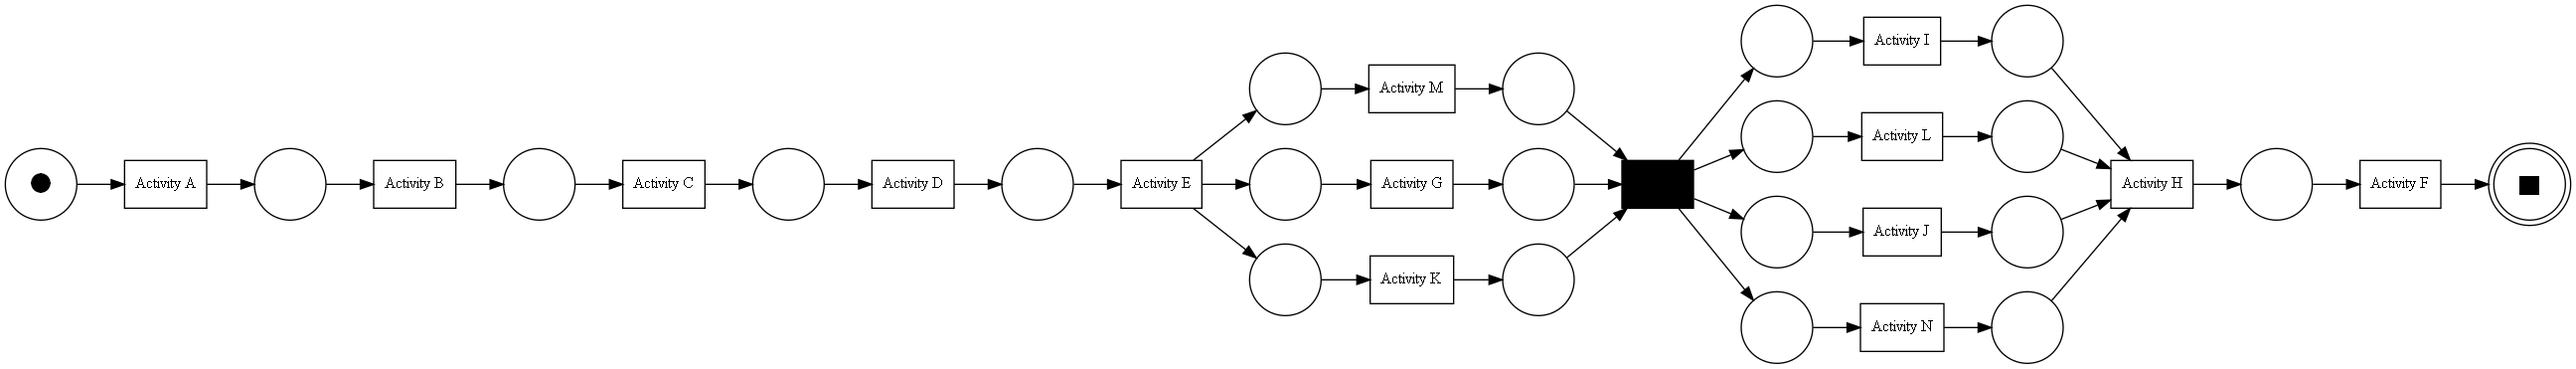

In [51]:
#visualizing the petri net
from pm4py.visualization.petri_net import visualizer as pn_visualizer
gviz3 = pn_visualizer.apply(petri_net_im_orig, initial_marking_orig, final_marking_orig)
pn_visualizer.view(gviz3)

We observe the given process model is close to the one discovered from the reconsturcted event log, which has a few more transitions owing to greater variability but overall structure is similar.

### Fitness of reconstructed event log on original petri net model
<hr>

#### 1. Using token based replay

In [52]:
fitness_of_recons = pm4py.fitness_token_based_replay(event_log, petri_net_im_orig, initial_marking_orig, final_marking_orig)

replaying log with TBR, completed variants ::   0%|          | 0/40 [00:00<?, ?it/s]

In [53]:
fitness_of_recons

{'perc_fit_traces': 96.3,
 'average_trace_fitness': 0.9946476423902904,
 'log_fitness': 0.995076399046191,
 'percentage_of_fitting_traces': 96.3}

#### 2. Using alignments

In [54]:
fitness_of_recons_alignment = pm4py.fitness_alignments(event_log, petri_net_im_orig, initial_marking_orig, final_marking_orig)

aligning log, completed variants ::   0%|          | 0/40 [00:00<?, ?it/s]

In [55]:
fitness_of_recons_alignment

{'percFitTraces': 96.3,
 'averageFitness': 0.9967857142857135,
 'percentage_of_fitting_traces': 96.3,
 'average_trace_fitness': 0.9967857142857135,
 'log_fitness': 0.9967821543494487}

### Fitness of original event log on petri net of reconstructed log
<hr>

#### 1. Using Token based replay

In [56]:
fitness_of_orig = pm4py.fitness_token_based_replay(event_log_orig, petri_net_im, initial_marking, final_marking)

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

In [57]:
fitness_of_orig

{'perc_fit_traces': 100.0,
 'average_trace_fitness': 1.0,
 'log_fitness': 1.0,
 'percentage_of_fitting_traces': 100.0}

#### 2. Using alignments

In [58]:
fitness_of_orig_alignment = pm4py.fitness_alignments(event_log_orig, petri_net_im, initial_marking, final_marking)

aligning log, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

In [59]:
fitness_of_orig_alignment

{'percFitTraces': 100.0,
 'averageFitness': 1.0,
 'percentage_of_fitting_traces': 100.0,
 'average_trace_fitness': 1.0,
 'log_fitness': 0.9999500011363378}

## Conformance Checking on reconstructed log and model

### 1. Token Based Replay

The output of the token-based replay, stored in the variable replayed_traces, contains for each trace of the log:

- trace_is_fit: boolean value (True/False) that is true when the trace is according to the model.
- activated_transitions: list of transitions activated in the model by the token-based replay.
- reached_marking: marking reached at the end of the replay.
- missing_tokens: number of missing tokens.
- consumed_tokens: number of consumed tokens.
- remaining_tokens: number of remaining tokens.
- produced_tokens: number of produced tokens.

In [60]:
replayed_traces_im = pm4py.conformance_diagnostics_token_based_replay(event_log, petri_net_im, initial_marking, final_marking)

replaying log with TBR, completed variants ::   0%|          | 0/40 [00:00<?, ?it/s]

In [61]:
replayed_traces_im[0]

{'trace_is_fit': True,
 'trace_fitness': 1.0,
 'activated_transitions': [(7211c563-00dd-4621-aea5-2bc61bd78fd4, 'Activity A'),
  (63d16318-d31a-4fc1-8a05-94a6bead2d2d, 'Activity B'),
  (53666492-d539-439e-a44b-f3e6542589f0, 'Activity C'),
  (7eb5c9b2-0029-41c2-812c-59099e679ad8, 'Activity D'),
  (40aeac1f-671c-4df5-8dee-500406c8dfef, 'Activity E'),
  (init_loop_4, None),
  (eebd0548-2cb5-4b41-a5d1-5c8dddf2e3c8, 'Activity K'),
  (init_loop_14, None),
  (cabd8ba8-77d0-4805-9faa-a30490c10ffe, 'Activity G'),
  (init_loop_9, None),
  (a5f52a86-25ec-4da8-b2ff-312a3bd9152c, 'Activity M'),
  (skip_7, None),
  (skip_12, None),
  (skip_17, None),
  (tauJoin_2, None),
  (init_loop_21, None),
  (3c15908e-bee2-458e-86b2-5238810b4e85, 'Activity L'),
  (9ecdb12d-546c-4108-94c7-a9ee3c0ea66d, 'Activity I'),
  (skip_27, None),
  (8145b108-4b8f-48cd-abbb-70d60087fd98, 'Activity J'),
  (skip_27, None),
  (71086467-dfdf-4a96-86cd-57e6376eda3b, 'Activity N'),
  (skip_24, None),
  (40c7d8ce-8ef4-434e-8a68-57

### 2. Diagnostics (TBR)

The execution of token-based replay in PM4Py permits to obtain detailed information about transitions that did not execute correctly, or activities that are in the log and not in the model. In particular, executions that do not match the model are expected to take longer throughput time.

Hence, we perform a Throughput analysis.

In [62]:
from pm4py.algo.conformance.tokenreplay import algorithm as token_based_replay

In [63]:
parameters_tbr = {token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.DISABLE_VARIANTS: True, token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.ENABLE_PLTR_FITNESS: True}

In [64]:
replayed_traces_im2, place_fitness, trans_fitness, unwanted_activities = token_based_replay.apply(event_log, petri_net_im,
                                                                                                  initial_marking,
                                                                                                  final_marking,
                                                                                                  parameters=parameters_tbr)

replaying log with TBR, completed variants ::   0%|          | 0/2000 [00:00<?, ?it/s]

In [65]:
replayed_traces_im2[0]

{'trace_is_fit': True,
 'trace_fitness': 1.0,
 'activated_transitions': [(7211c563-00dd-4621-aea5-2bc61bd78fd4, 'Activity A'),
  (63d16318-d31a-4fc1-8a05-94a6bead2d2d, 'Activity B'),
  (53666492-d539-439e-a44b-f3e6542589f0, 'Activity C'),
  (7eb5c9b2-0029-41c2-812c-59099e679ad8, 'Activity D'),
  (40aeac1f-671c-4df5-8dee-500406c8dfef, 'Activity E'),
  (init_loop_4, None),
  (eebd0548-2cb5-4b41-a5d1-5c8dddf2e3c8, 'Activity K'),
  (init_loop_14, None),
  (cabd8ba8-77d0-4805-9faa-a30490c10ffe, 'Activity G'),
  (init_loop_9, None),
  (a5f52a86-25ec-4da8-b2ff-312a3bd9152c, 'Activity M'),
  (skip_7, None),
  (skip_12, None),
  (skip_17, None),
  (tauJoin_2, None),
  (init_loop_21, None),
  (3c15908e-bee2-458e-86b2-5238810b4e85, 'Activity L'),
  (9ecdb12d-546c-4108-94c7-a9ee3c0ea66d, 'Activity I'),
  (skip_27, None),
  (8145b108-4b8f-48cd-abbb-70d60087fd98, 'Activity J'),
  (skip_27, None),
  (71086467-dfdf-4a96-86cd-57e6376eda3b, 'Activity N'),
  (skip_24, None),
  (40c7d8ce-8ef4-434e-8a68-57

### 3. Throughput analysis for transitions executed unfit

In [66]:
from pm4py.algo.conformance.tokenreplay.diagnostics import duration_diagnostics

In [67]:
trans_diagnostics = duration_diagnostics.diagnose_from_trans_fitness(event_log, trans_fitness)

In [68]:
trans_diagnostics

{}

In [69]:
for trans in trans_diagnostics:
    print(trans, trans_diagnostics[trans])

This means all transitions were executed.

### 4. Throughput analysis for unwanted activities

In [70]:
act_diagnostics = duration_diagnostics.diagnose_from_notexisting_activities(event_log, unwanted_activities)
for act in act_diagnostics:
    print(act, act_diagnostics[act])

In [77]:
act_diagnostics

{}

### 5. Evaluating distribution of events over time

Here, we obtain a graph representing the distribution of events over time. It helps to understand in which time intervals the greatest number of events is recorded. The distribution related to events over time may be obtained.

In [71]:
from pm4py.algo.filtering.log.attributes import attributes_filter

In [72]:
x, y = attributes_filter.get_kde_date_attribute(event_log, attribute="time:timestamp")

In [73]:
from pm4py.visualization.graphs import visualizer as graphs_visualizer

C:\Users\AREFA\miniconda3\envs\papercodeenv\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\AREFA\miniconda3\envs\papercodeenv\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\AREFA\miniconda3\envs\papercodeenv\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\AREFA\miniconda3\envs\papercodeenv\lib\site-packages\pm4py\visualization\graphs\variants\dates.py:85: UserWarn

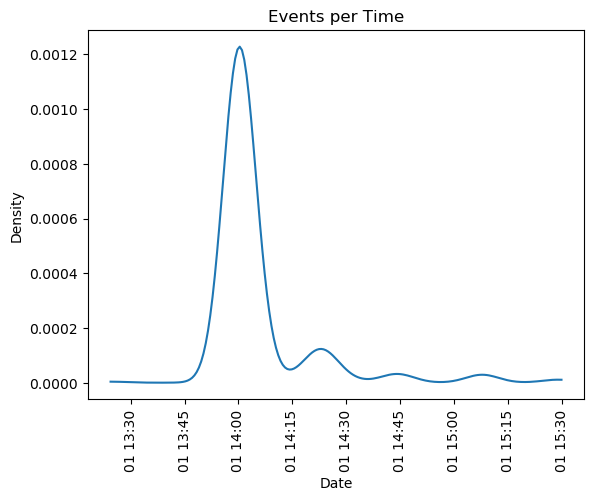

In [74]:
gviz_time = graphs_visualizer.apply_plot(x, y, variant=graphs_visualizer.Variants.DATES)
graphs_visualizer.view(gviz_time)

### 6. Distribution of events

Observing the distribution of events over time permits to infer useful information about the work shifts, the working days, and the period of the year that are more or less busy.

The possible values for the parameter distr_type are:

- hours: plots the distribution over the hours of a day.
- days_week: plots the distribution over the days of a week.
- days_month: plots the distribution over the days of a month.
- months: plots the distribution over the months of a year.
- years: plots the distribution over the different years of the log.

#### i) Reconstructed event log

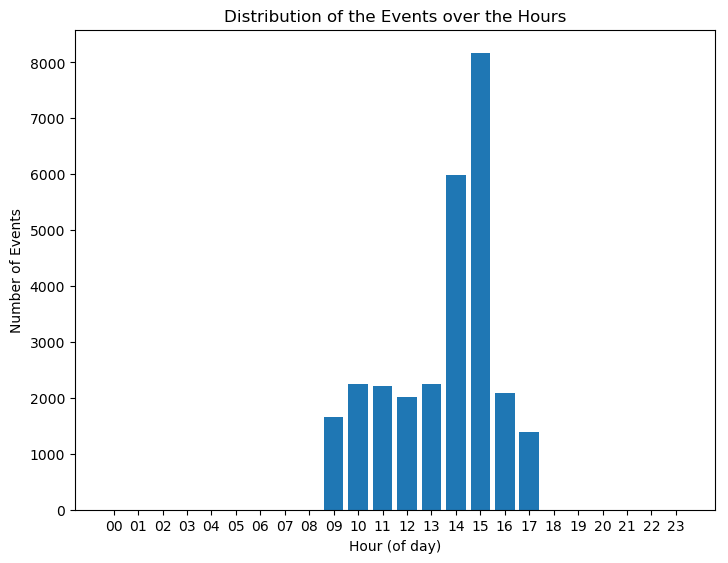

In [75]:
pm4py.view_events_distribution_graph(event_log, distr_type="hours", format="png")

#### ii) Original event log

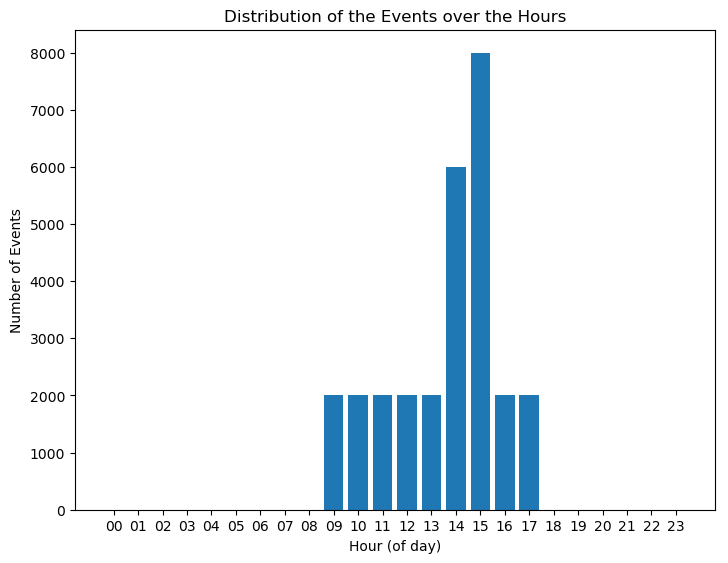

In [76]:
pm4py.view_events_distribution_graph(event_log_orig, distr_type="hours", format="png")

In [1]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


### 7. Comparing average activity durations

In [83]:
true_act = submission[[ 'TrueActivity', 'TrueTime']]
true_act.head()

,TrueActivity,TrueTime
0,Activity A,0.0
1,Activity B,3600.0
2,Activity C,7200.0
3,Activity D,10800.0
4,Activity E,14400.0


In [84]:
predicted_act = submission[[ 'PredictedActivity', 'PredictedTime']]
predicted_act.head()

,PredictedActivity,PredictedTime
0,Activity A,0.000000
1,Activity B,3600.000000
2,Activity C,7200.000000
3,Activity D,9395.238465
4,Activity E,14400.000000


In [87]:
true_act_avgtime = pd.DataFrame(true_act.groupby('TrueActivity')['TrueTime'].mean())
true_act_avgtime

,TrueTime
TrueActivity,
Activity A,0.0
Activity B,3600.0
Activity C,7200.0
Activity D,10800.0
Activity E,14400.0
Activity F,28800.0
Activity G,18000.0
Activity H,25200.0
Activity I,21600.0


In [90]:
pred_act_avgtime = pd.DataFrame(predicted_act.groupby('PredictedActivity')['PredictedTime'].mean())
pred_act_avgtime

,PredictedTime
PredictedActivity,
Activity A,1623.660553
Activity B,4258.370428
Activity C,7712.263700
Activity D,11044.803207
Activity E,14487.116081
Activity F,27329.401536
Activity G,18167.608048
Activity H,24876.882993
Activity I,21725.163738


In [93]:
merged_act_df = pd.concat([true_act_avgtime,pred_act_avgtime], axis=1)
merged_act_df

,TrueTime,PredictedTime
Activity A,0.0,1623.660553
Activity B,3600.0,4258.370428
Activity C,7200.0,7712.263700
Activity D,10800.0,11044.803207
Activity E,14400.0,14487.116081
Activity F,28800.0,27329.401536
Activity G,18000.0,18167.608048
Activity H,25200.0,24876.882993
Activity I,21600.0,21725.163738
Activity J,21600.0,21719.886568


In [95]:
merged_act_df['activity'] = merged_act_df.index

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

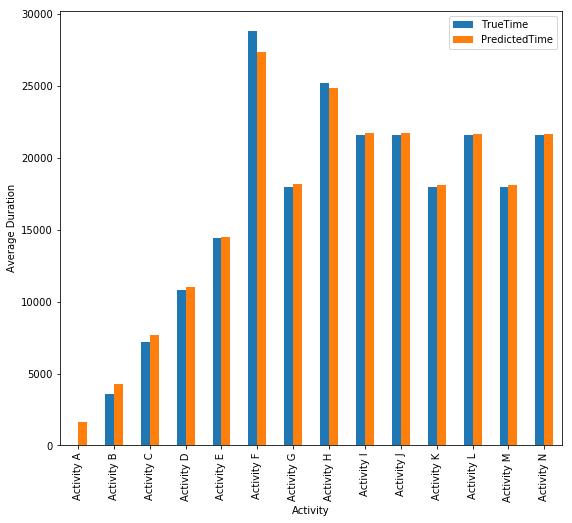

In [104]:
merged_act_df.plot(x="activity", y=["TrueTime", 'PredictedTime'], kind="bar",figsize=(9,8))
plt.xlabel("Activity")
plt.ylabel("Average Duration")
plt.show()

In [ ]:
def compute_avg_perc_error(true_values, pred_values):
    res = 0
    for i in range(1, len(true_values)):
        error = abs(true_values[i] - pred_values[i])
        error = error/(true_values[i] + 1e-6) * 100
        res += error
    return res/len(true_values)

In [ ]:
compute_avg_perc_error(list(merged_act_df['TrueTime']), list(merged_act_df['PredictedTime']))

2.7653488423438177